<a href="https://colab.research.google.com/github/fidanfatih/Fraud_Detection/blob/main/fraud_detection_phase8a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Read dataset

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder
# from category_encoders import CountEncoder
import re
import gc
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

%matplotlib inline

# pd.options.display.max_rows = 1000
# pd.options.display.max_columns = 1000
# pd.options.display.max_colwidth = 1000

In [177]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Export Data

In [178]:
# safe downcast
def sd(col, max_loss_limit=0.001, avg_loss_limit=0.001, na_loss_limit=0, n_uniq_loss_limit=0, fillna=0):
    """
    max_loss_limit - don't allow any float to lose precision more than this value. Any values are ok for GBT algorithms as long as you don't unique values.
                     See https://en.wikipedia.org/wiki/Half-precision_floating-point_format#Precision_limitations_on_decimal_values_in_[0,_1]
    avg_loss_limit - same but calculates avg throughout the series.
    na_loss_limit - not really useful.
    n_uniq_loss_limit - very important parameter. If you have a float field with very high cardinality you can set this value to something like n_records * 0.01 in order to allow some field relaxing.
    """
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)
    try_types = ['float16', 'float32']

    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    for type in try_types:
        col_tmp = col

        # float to int conversion => try to round to minimize casting error
        if is_float and (str(type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        col_tmp = col_tmp.astype(type)
        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        if max_loss <= max_loss_limit and avg_loss <= avg_loss_limit and na_loss <= na_loss_limit and n_uniq_loss <= n_uniq_loss_limit:
            return col_tmp

    # field can't be converted
    return col

def reduce_mem_usage_sd(df, deep=True, verbose=False, obj_to_cat=False):
    numerics = ['int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes

        # collect stats
        na_count = df[col].isna().sum()
        n_uniq = df[col].nunique(dropna=False)
        
        # numerics
        if col_type in numerics:
            df[col] = sd(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')
        
        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}, na_count={na_count}, n_uniq={n_uniq}')
        new_na_count = df[col].isna().sum()
        if (na_count != new_na_count):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost na values. Before: {na_count}, after: {new_na_count}')
        new_n_uniq = df[col].nunique(dropna=False)
        if (n_uniq != new_n_uniq):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost unique values. Before: {n_uniq}, after: {new_n_uniq}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    if verbose:
        print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

In [179]:
# df = reduce_mem_usage_sd(df, verbose=True)
# df.to_csv('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/after_eda_phase7.csv')
df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/after_eda_phase7.csv', index_col=[0])
df = reduce_mem_usage_sd(df, verbose=True)
gc.collect()

Column isFraud: int64 -> int8, na_count=0, n_uniq=2
Column TransactionAmt: float64 -> float32, na_count=0, n_uniq=20902
Column card1: int64 -> int16, na_count=0, n_uniq=13553
Column card2: int64 -> int16, na_count=0, n_uniq=501
Column card3: int64 -> int16, na_count=0, n_uniq=115
Column card5: int64 -> int16, na_count=0, n_uniq=120
Column addr1: int64 -> int16, na_count=0, n_uniq=332
Column dist1: int64 -> int16, na_count=0, n_uniq=2651
Column C1: int64 -> int16, na_count=0, n_uniq=1657
Column C5: int64 -> int16, na_count=0, n_uniq=319
Column C13: int64 -> int16, na_count=0, n_uniq=1597
Column D1: int64 -> int16, na_count=0, n_uniq=641
Column D3: int64 -> int16, na_count=0, n_uniq=649
Column D4: int64 -> int16, na_count=0, n_uniq=808
Column D5: int64 -> int16, na_count=0, n_uniq=688
Column D8: float64 -> float32, na_count=0, n_uniq=12353
Column D9: float64 -> float16, na_count=0, n_uniq=24
Column D10: int64 -> int16, na_count=0, n_uniq=818
Column D11: int64 -> int16, na_count=0, n_uniq

82

In [180]:
df.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,dist1,C1,C5,C13,D1,D3,D4,D5,D8,D9,D10,D11,D13,D14,D15,id_01,id_02,id_03,id_05,id_06,id_09,id_10,id_11,id_13,id_14,id_17,id_19,id_20,id_32,id_33,Transaction_hour,Transaction_day_of_week,TransactionAmt_to_mean_card1,...,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1,TransactionAmt_decimal,TransactionAmt_winsorize,TransactionAmt_log,TransactionAmt_sqrt,TransactionAmt_z,pca_V1,pca_V2,ProductCD_freq,DeviceInfo_freq,DeviceType_freq,R_emaildomain_1_freq,R_emaildomain_2_freq,R_emaildomain_3_freq,P_emaildomain_1_freq,P_emaildomain_2_freq,P_emaildomain_3_freq,id_12_freq,id_28_freq,id_30_freq,id_31_freq,id_34_freq,id_35_freq,id_36_freq,id_37_freq,id_38_freq,M2_freq,M3_freq,M4_freq,M5_freq,M6_freq,M7_freq,M8_freq,M9_freq,card4_freq,card6_freq
0,0,68.5,13926,-999,150,142,315,19,1,0,1,14,13,26,10,37.875,0.666504,13,13,0,0,0,-999,125800.5,-999,-999,-999,-999,-999,100.0,-999,-999,-999,341,472,-999,2073600,0,0,0.194640,...,0.0000,0.000000,0.000000,0.0000,0.000000,500,8.276473,5.226834,8.276473,-0.278167,-1326.3132,938.8965,0.744629,0.798828,0.761719,0.767578,0.767578,0.995605,0.159912,0.160767,0.994629,0.755859,0.761230,0.868652,0.762695,0.868164,0.761230,0.761230,0.761230,0.761230,0.483398,0.426270,0.101379,0.224365,0.327393,0.586426,0.586426,0.586426,0.011261,0.252197
1,0,29.0,2755,404,150,102,325,8,1,0,1,0,8,0,10,37.875,0.666504,0,43,0,0,0,-999,125800.5,-999,-999,-999,-999,-999,100.0,-999,-999,-999,341,472,-999,2073600,0,0,0.123777,...,0.0000,0.000000,0.000000,0.0000,0.000000,0,5.385165,4.367296,5.385165,-0.443327,-1162.1685,623.2542,0.744629,0.798828,0.761719,0.767578,0.767578,0.995605,0.387451,0.793457,0.994629,0.755859,0.761230,0.868652,0.762695,0.868164,0.761230,0.761230,0.761230,0.761230,0.458984,0.458984,0.332520,0.182129,0.327393,0.586426,0.586426,0.586426,0.320312,0.252197
2,0,59.0,4663,490,150,166,330,287,1,0,1,0,8,0,10,37.875,0.666504,0,315,0,0,315,-999,125800.5,-999,-999,-999,-999,-999,100.0,-999,-999,-999,341,472,-999,2073600,0,0,0.608150,...,1.8650,1.851016,1.541448,1.6110,1.486472,0,7.681146,5.077538,7.681146,-0.317889,-1719.8655,1228.5214,0.744629,0.798828,0.761719,0.767578,0.767578,0.995605,0.009369,0.793457,0.994629,0.755859,0.761230,0.868652,0.762695,0.868164,0.761230,0.761230,0.761230,0.761230,0.483398,0.426270,0.332520,0.224365,0.385742,0.357910,0.262939,0.065430,0.651367,0.745117
3,0,50.0,18132,567,150,117,476,8,2,0,25,112,0,94,0,37.875,0.666504,84,43,0,0,111,-999,125800.5,-999,-999,-999,-999,-999,100.0,-999,-999,-999,341,472,-999,2073600,0,0,0.405133,...,0.7200,0.520531,0.558392,0.6860,0.576638,0,7.071068,4.912023,7.071068,-0.355521,-1157.4513,646.5151,0.744629,0.798828,0.761719,0.767578,0.767578,0.995605,0.174316,0.793457,0.994629,0.755859,0.761230,0.868652,0.762695,0.868164,0.761230,0.761230,0.761230,0.761230,0.458984,0.458984,0.332520,0.182129,0.385742,0.586426,0.586426,0.586426,0.320312,0.745117
4,0,50.0,4497,514,150,102,420,8,1,0,1,0,8,26,10,37.875,0.666504,15,43,0,0,52,0,70787.0,-999,-999,-999,-999,-999,100.0,-999,-480,166,542,144,32,2397600,0,0,0.515612,...,0.3198,0.323874,0.256558,0.4595,0.408718,0,7.071068,4.912023,7.071068,-0.355521,8948.4090,-1581.1727,0.055908,0.020248,0.094238,0.767578,0.767578,0.995605,0.387451,0.793457,0.994629,0.208374,0.109619,0.010674,0.003805,0.101624,0.131714,0.227051,0.187012,0.113586,0.458984,0.458984,0.476562,0.593262,0.286865,0.586426,0.586426,0.586426,0.320312,0.252197


### Modeling with LightGBM

In [181]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

# for modeling 
import sklearn
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, recall_score, f1_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve, plot_roc_curve, roc_curve, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import datasets, metrics
from sklearn.decomposition import PCA

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")



warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [182]:
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state =42)

In [183]:
# LGBMClassifier with GPU

clf = LGBMClassifier(
          num_leaves = 256,
          min_child_samples = 79,
          objective = 'binary',
          max_depth = 13,
          learning_rate = 0.03,
          boosting_type = "gbdt",
          subsample_freq = 3,
          subsample = 0.9,
          bagging_seed = 11,
          metric = 'auc',
          verbosity = -1,
          reg_alpha = 0.3,
          reg_lambda = 0.3,
          colsample_bytree = 0.9,
          is_unbalance = True,
)

In [184]:
%time clf.fit(X, y)

CPU times: user 2min 8s, sys: 1.25 s, total: 2min 9s
Wall time: 1min 7s


LGBMClassifier(bagging_seed=11, boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9, importance_type='split', is_unbalance=True,
               learning_rate=0.03, max_depth=13, metric='auc',
               min_child_samples=79, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=256, objective='binary',
               random_state=None, reg_alpha=0.3, reg_lambda=0.3, silent=True,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=3,
               verbosity=-1)

In [185]:
gc.collect()

255

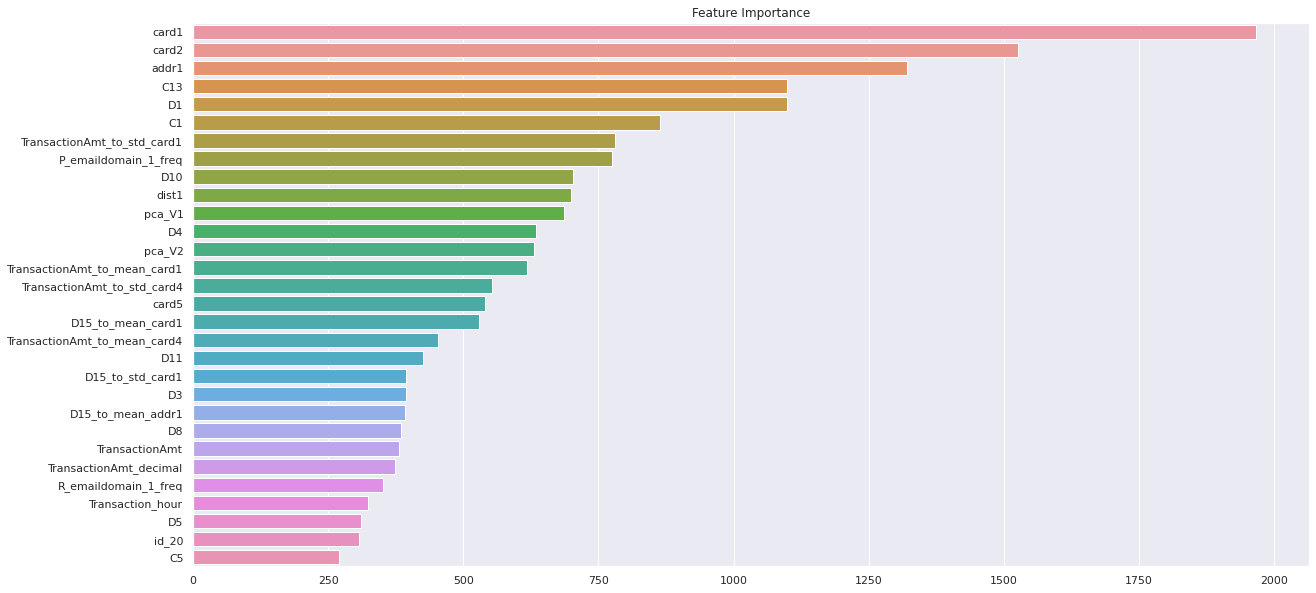

In [360]:
def plot_feature_importances(model, num=10, figsize=(20,10)):
    feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:num]
    plt.figure(figsize=figsize)
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance")
    plt.show()

plot_feature_importances(clf, 30)

### Evaluation of LightGBM

In [187]:
# plot_confusion_matrix(clf, X_test, y_test, values_format = '', 
#                       display_labels=['Not Fraud', 'Fraud'])
# plt.grid(None)
# print(classification_report(y_test, y_pred, zero_division=0))

In [188]:
# # Alternative
# group_names = ['True Neg','False Pos','False Neg','True Pos']
# cf_matrix = confusion_matrix(y_test,y_pred)
# group_counts = ["{0:0.0f}".format(value) for value in
#                 cf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in
#                      cf_matrix.flatten()/np.sum(cf_matrix)]
# labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
#           zip(group_names,group_counts,group_percentages)]
# labels = np.asarray(labels).reshape(2,2)
# sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');

In [189]:
# y_train_pred = clf.predict(X_train)
# plot_confusion_matrix(clf, X_train, y_train, values_format = '', 
#                       display_labels=['Not Fraud', 'Fraud'])
# plt.grid(None)
# print(classification_report(y_train, y_train_pred, zero_division=0))

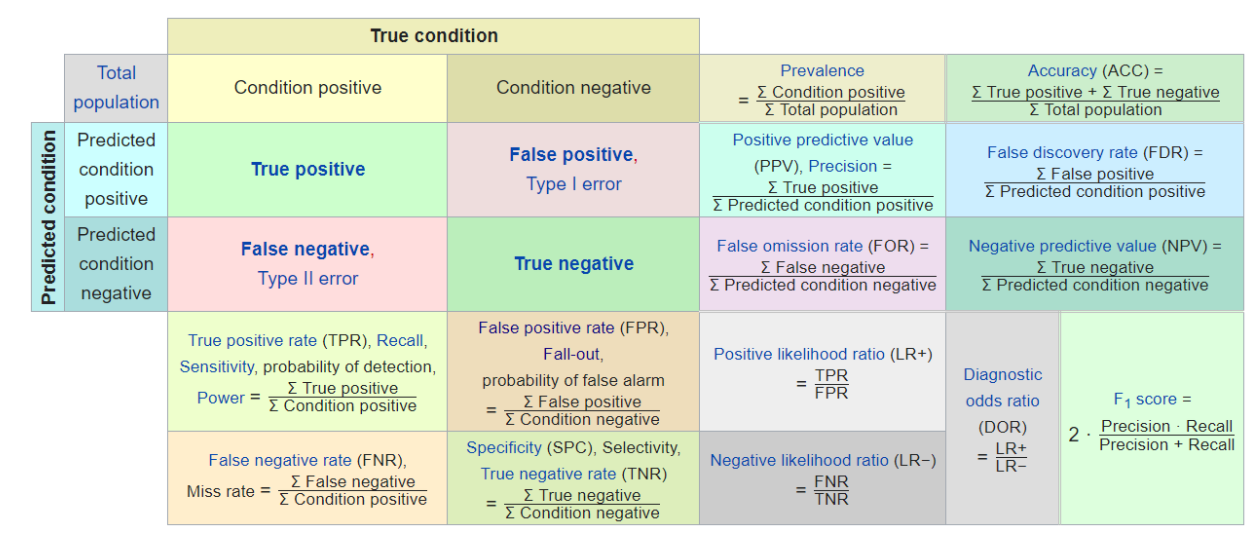

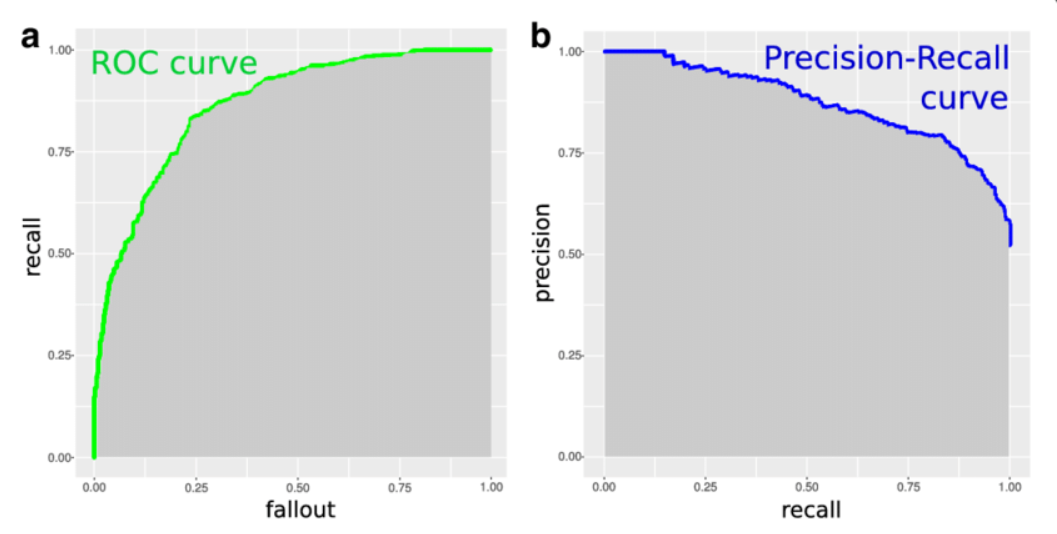

In [190]:
# from sklearn.metrics import plot_precision_recall_curve

# plt.figure(figsize=(10,10))
# disp = plot_precision_recall_curve(clf, X_test, y_test)
# disp.ax_.set_title('Precision-Recall curve');

In [191]:
# from sklearn import metrics

# clf.fit(X_train, y_train)
# y_pred = clf.predict_proba(X_test)[:, 1]

# auc = metrics.roc_auc_score(y_test, y_pred)

# false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

# plt.figure(figsize=(8, 8), dpi=100)
# plt.axis('scaled')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.title("AUC & ROC Curve")
# plt.plot(false_positive_rate, true_positive_rate, 'g')
# plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
# plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.show()

In [192]:
# scores = cross_val_score(clf, X_train, y_train, cv=10)
# print('>> Mean CV score is: ', round(np.mean(scores),3))
# pltt = sns.distplot(pd.Series(scores,name='CV scores distribution'), color='r')

In [193]:
# scores = cross_val_score(clf, X_test, y_test, cv=10)
# print('>> Mean CV score is: ', round(np.mean(scores),3))
# pltt = sns.distplot(pd.Series(scores,name='CV scores distribution'), color='r')

In [194]:
# from yellowbrick.classifier import ROCAUC, roc_auc

# roc_auc(clf, X_test, y_test) 

### Save and Export the Model as .pkl

In [195]:
import pickle
import pandas as pd

In [196]:
pickle.dump(clf,open("/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/lightGBM.pkl","wb"))

In [197]:
lightGBM_model = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/lightGBM.pkl","rb"))

In [361]:
features = df.columns.tolist()
features.remove('isFraud')
pd.DataFrame({'Value':clf.feature_importances_,'Feature':features}).sort_values(by="Value",ascending=False)['Feature'][:30].values

array(['card1', 'card2', 'addr1', 'C13', 'D1', 'C1',
       'TransactionAmt_to_std_card1', 'P_emaildomain_1_freq', 'D10',
       'dist1', 'pca_V1', 'D4', 'pca_V2', 'TransactionAmt_to_mean_card1',
       'TransactionAmt_to_std_card4', 'card5', 'D15_to_mean_card1',
       'TransactionAmt_to_mean_card4', 'D11', 'D15_to_std_card1', 'D3',
       'D15_to_mean_addr1', 'D8', 'TransactionAmt',
       'TransactionAmt_decimal', 'R_emaildomain_1_freq',
       'Transaction_hour', 'D5', 'id_20', 'card6_freq'], dtype=object)

In [199]:
df_raw= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/raw_data_phase7.csv', index_col=[0])
df_raw

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,dist1,C1,C5,C13,D1,D3,D4,D5,D8,D9,D10,D11,D13,D14,D15,M2,M3,M4,M5,M6,M7,M8,M9,V2,V3,V4,V6,V7,V8,V9,...,id_20,id_28,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,Transaction_hour,Transaction_day_of_week,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,id_02_to_mean_card1,id_02_to_mean_card4,id_02_to_std_card1,id_02_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1,TransactionAmt_decimal,TransactionAmt_winsorize,TransactionAmt_log,TransactionAmt_sqrt,TransactionAmt_z
0,0,68.50,W,13926,-999.0,150.0,discover,142.0,credit,315.0,19.0,1,0,1,14.0,13.0,26.0,10.0,37.875,0.6665,13.0,13.0,0.0,0.0,0.0,T,T,M2,F,T,None,None,None,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,472.0,None,None,None,-999.0,2073600.0,None,None,None,None,None,None,None,0.0,0.0,None,None,None,None,None,None,0.194640,0.257761,0.184566,0.170233,0.807175,0.727107,1.014720,0.799022,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,500,8.276473,5.226834,8.276473,-0.278167
1,0,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,8.0,1,0,1,0.0,8.0,0.0,10.0,37.875,0.6665,0.0,43.0,0.0,0.0,0.0,None,None,M0,T,T,None,None,None,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,472.0,None,None,None,-999.0,2073600.0,None,None,None,None,None,None,None,0.0,0.0,None,None,None,gmail,com,None,0.123777,0.219054,0.062995,0.114212,0.807175,0.727107,1.014720,0.799022,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0,5.385165,4.367296,5.385165,-0.443327
2,0,59.00,W,4663,490.0,150.0,visa,166.0,debit,330.0,287.0,1,0,1,0.0,8.0,0.0,10.0,37.875,0.6665,0.0,315.0,0.0,0.0,315.0,T,T,M0,F,F,F,F,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,472.0,None,None,None,-999.0,2073600.0,None,None,None,None,None,None,None,0.0,0.0,None,None,None,outlook,com,None,0.608150,0.443070,0.589241,0.258544,0.807175,0.727107,1.014720,0.799022,2.52000,1.86500,1.851016,1.541448,1.611000,1.486472,0,7.681146,5.077537,7.681146,-0.317889
3,0,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,8.0,2,0,25,112.0,0.0,94.0,0.0,37.875,0.6665,84.0,43.0,0.0,0.0,111.0,None,None,M0,T,F,None,None,None,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,472.0,None,None,None,-999.0,2073600.0,None,None,None,None,None,None,None,0.0,0.0,None,None,None,yahoo,com,None,0.405133,0.377678,0.259447,0.196917,0.807175,0.727107,1.014720,0.799022,0.55030,0.72000,0.520531,0.558392,0.686000,0.576638,0,7.071068,4.912023,7.071068,-0.355521
4,0,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,8.0,1,0,1,0.0,8.0,26.0,10.0,37.875,0.6665,15.0,43.0,0.0,0.0,52.0,None,None,None,None,None,None,None,None,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,144.0,New,android,samsung_browser,32.0,2397600.0,match_status:2,T,F,T,T,mobile,samsung,0.0,0.0,None,None,None,gmail,com,None,0.515612,0.377678,0.882933,0.196917,0.764773,0.373295,1.753301,0.425884,0.38750,0.31980,0.323874,0.256558,0.459500,0.408718,0,7.071068,4.912023,7.071068,-0.355521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0,49.00,W,6550,-999.0,150.0,visa,226.0,debit,272.0,48.0,2,1,3,29.0,30.0,26.0,10.0,37.875,0.6665,56.0,56.0,0.0,0.0,56.0,T,T,M0,T,F,F,F,T,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,472.0,None,None,None,-999.0,2073600.0,None,None,None,None,None,None,None,23.0,6.0,None,None,None,None,None,None,0.505177,0.367973,0.363843,0.214723,0.807175,0.727107,1.014720,0.799022,0.30790,0.33150,0.269218,0.274035,0.330600,0.276139,0,7.000000,4.891820,7.000000,-0.359702
590536,0,39.50,W,10444,225.0,150.0,masterc

In [348]:
FE_dict= dict()
FE_dict['R_emaildomain_1_freq'] = df_raw['R_emaildomain_1'].value_counts(dropna=False, normalize=True).to_dict()
FE_dict['P_emaildomain_1_freq'] = df_raw['P_emaildomain_1'].value_counts(dropna=False, normalize=True).to_dict()
FE_dict['card4_freq'] = df_raw['card4'].value_counts(dropna=False, normalize=True).to_dict()

FE_dict['TransactionAmt_to_std_card1'] = df_raw[['card1','TransactionAmt_to_std_card1']].drop_duplicates().set_index('card1').T.iloc[0].sort_index().to_dict()
FE_dict['TransactionAmt_to_mean_card1'] = df_raw[['card1','TransactionAmt_to_mean_card1']].drop_duplicates().set_index('card1').T.iloc[0].sort_index().to_dict()
FE_dict['TransactionAmt_to_std_card4']= df_raw[['card4','TransactionAmt_to_std_card4']].drop_duplicates().set_index('card4').T.iloc[0].sort_index().to_dict()
FE_dict['TransactionAmt_to_mean_card4'] = df_raw[['card4','TransactionAmt_to_mean_card4']].drop_duplicates().set_index('card4').T.iloc[0].sort_index().to_dict()
FE_dict['D15_to_mean_card1'] = df_raw[['card1','D15_to_mean_card1']].drop_duplicates().set_index('card1').T.iloc[0].sort_index().to_dict()
FE_dict['D15_to_std_card1'] = df_raw[['card1','D15_to_std_card1']].drop_duplicates().set_index('card1').T.iloc[0].sort_index().to_dict()
FE_dict['D15_to_mean_addr1'] = df_raw[['addr1','D15_to_mean_addr1']].drop_duplicates().set_index('addr1').T.iloc[0].sort_index().to_dict()

In [349]:
with open('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/FE_dict.pkl', 'wb') as handle:
    pickle.dump(FE_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/FE_dict.pkl', 'rb') as handle:
    FE_dict = pickle.load(handle)

In [406]:
row_number = 270819  #474470, 150254, 270819 >> fraud

features= ['card1', 'card2', 'card4', 'card5', 
           'D1', 'D3', 'D4', 'D5', 'D8', 'D10', 'D11', 'D15', 
           'C1', 'C5', 'C13', 
           'R_emaildomain_1', 'P_emaildomain_1', 
           'TransactionAmt', 'addr1', 'dist1', 
           'Transaction_hour', 'Transaction_day_of_week', 
           'id_19', 'id_20', 'id_33']

my_dict = {col:np.nan for col in features}

for col in features:
  my_dict[col] = df_raw.loc[row_number, my_dict.keys()][col]

# Feature Engineering
my_dict['TransactionAmt_to_std_card1'] = FE_dict['TransactionAmt_to_std_card1'][my_dict['card1']]
my_dict['TransactionAmt_to_mean_card1'] = FE_dict['TransactionAmt_to_mean_card1'][my_dict['card1']]
my_dict['TransactionAmt_to_std_card4'] = FE_dict['TransactionAmt_to_std_card4'][my_dict['card4']]
my_dict['D15_to_mean_card1'] = FE_dict['D15_to_mean_card1'][my_dict['card1']]
my_dict['D15_to_std_card1'] = FE_dict['D15_to_std_card1'][my_dict['card1']]
my_dict['TransactionAmt_to_mean_card4'] = FE_dict['TransactionAmt_to_mean_card4'][my_dict['card4']]
my_dict['D15_to_mean_addr1'] = FE_dict['D15_to_mean_addr1'][my_dict['addr1']]

my_dict['TransactionAmt_decimal'] = (my_dict['TransactionAmt']-np.floor(my_dict['TransactionAmt']))*100

# Frequency Encoding
my_dict['P_emaildomain_1_freq'] = FE_dict['P_emaildomain_1_freq'][my_dict['P_emaildomain_1']]
my_dict['R_emaildomain_1_freq'] = FE_dict['R_emaildomain_1_freq'] [my_dict['R_emaildomain_1']]
my_dict['card4_freq'] = FE_dict['card4_freq'][my_dict['card4']]

my_dict = pd.DataFrame([my_dict]).drop(['card4', 'R_emaildomain_1', 'P_emaildomain_1'], axis=1)

In [351]:
# all_columns=df.drop('isFraud',axis=1).columns
all_columns = ['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'dist1',
       'C1', 'C5', 'C13', 'D1', 'D3', 'D4', 'D5', 'D8', 'D9', 'D10', 'D11',
       'D13', 'D14', 'D15', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06',
       'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 'id_17', 'id_19', 'id_20',
       'id_32', 'id_33', 'Transaction_hour', 'Transaction_day_of_week',
       'TransactionAmt_to_mean_card1', 'TransactionAmt_to_mean_card4',
       'TransactionAmt_to_std_card1', 'TransactionAmt_to_std_card4',
       'id_02_to_mean_card1', 'id_02_to_mean_card4', 'id_02_to_std_card1',
       'id_02_to_std_card4', 'D15_to_mean_card1', 'D15_to_mean_card4',
       'D15_to_std_card1', 'D15_to_std_card4', 'D15_to_mean_addr1',
       'D15_to_std_addr1', 'TransactionAmt_decimal',
       'TransactionAmt_winsorize', 'TransactionAmt_log', 'TransactionAmt_sqrt',
       'TransactionAmt_z', 'pca_V1', 'pca_V2', 'ProductCD_freq',
       'DeviceInfo_freq', 'DeviceType_freq', 'R_emaildomain_1_freq',
       'R_emaildomain_2_freq', 'R_emaildomain_3_freq', 'P_emaildomain_1_freq',
       'P_emaildomain_2_freq', 'P_emaildomain_3_freq', 'id_12_freq',
       'id_28_freq', 'id_30_freq', 'id_31_freq', 'id_34_freq', 'id_35_freq',
       'id_36_freq', 'id_37_freq', 'id_38_freq', 'M2_freq', 'M3_freq',
       'M4_freq', 'M5_freq', 'M6_freq', 'M7_freq', 'M8_freq', 'M9_freq',
       'card4_freq', 'card6_freq']

In [352]:
X = my_dict.reindex(columns=all_columns, fill_value=0)
X

,TransactionAmt,card1,card2,card3,card5,addr1,dist1,C1,C5,C13,D1,D3,D4,D5,D8,D9,D10,D11,D13,D14,D15,id_01,id_02,id_03,id_05,id_06,id_09,id_10,id_11,id_13,id_14,id_17,id_19,id_20,id_32,id_33,Transaction_hour,Transaction_day_of_week,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,...,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1,TransactionAmt_decimal,TransactionAmt_winsorize,TransactionAmt_log,TransactionAmt_sqrt,TransactionAmt_z,pca_V1,pca_V2,ProductCD_freq,DeviceInfo_freq,DeviceType_freq,R_emaildomain_1_freq,R_emaildomain_2_freq,R_emaildomain_3_freq,P_emaildomain_1_freq,P_emaildomain_2_freq,P_emaildomain_3_freq,id_12_freq,id_28_freq,id_30_freq,id_31_freq,id_34_freq,id_35_freq,id_36_freq,id_37_freq,id_38_freq,M2_freq,M3_freq,M4_freq,M5_freq,M6_freq,M7_freq,M8_freq,M9_freq,card4_freq,card6_freq
0,17.643,8755,500.0,0,224.0,299.0,8.0,4,0,0,0.0,8.0,22.0,0.0,0.958333,0,0.0,43.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,153.0,325.0,0,2073600.0,23.0,4.0,0.651021,0.233481,...,0,3.183128,0,0.2319,0,64.3,0,0,0,0,0,0,0,0,0,0.096932,0,0,0.387528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.320414,0


In [353]:
prediction = lightGBM_model.predict(X)
print("The Fraud : ",'Yes' if prediction[0] else 'No')

The Fraud :  Yes


In [354]:
prediction = lightGBM_model.predict_proba(X)
print(f'The Fraud Probability of the transaction is %{round(prediction[0][1]*100,1)}')

The Fraud Probability of the transaction is %79.2


In [ ]:
# pip freeze

In [ ]:
# df_raw[[col for col in df_raw.columns if re.search('^id_', col)]].mode().T

### Modeling with XGBoost

In [ ]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

# for modeling 
import sklearn
from lightgbm import LGBMClassifier
# from xgboost.sklearn import XGBClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, recall_score, f1_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve, plot_roc_curve, roc_curve, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import datasets, metrics
from sklearn.decomposition import PCA

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")



warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [ ]:
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state =42)

In [ ]:
xgb = XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        # USE CPU
        #nthread=4,
        #tree_method='hist' 
        # USE GPU
        tree_method='gpu_hist' 
    )

In [ ]:
%time xgb.fit(X_train, y_train)

In [ ]:
gc.collect()

In [ ]:
def plot_feature_importances(model, num=10, figsize=(20,10)):
    feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:num]
    plt.figure(figsize=figsize)
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance")
    plt.show()
    
plot_feature_importances(xgb, 30)

In [ ]:
y_pred = xgb.predict(X_test)

### Evaluation of XgGBoost

In [ ]:
plot_confusion_matrix(xgb, X_test, y_test, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_test, y_pred, zero_division=0))

In [ ]:
# Alternative
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix = confusion_matrix(y_test,y_pred)
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');

In [ ]:
y_train_pred = xgb.predict(X_train)
plot_confusion_matrix(xgb, X_train, y_train, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_train, y_train_pred, zero_division=0))

In [ ]:
from sklearn.metrics import plot_precision_recall_curve

plt.figure(figsize=(10,10))
disp = plot_precision_recall_curve(xgb, X_test, y_test)
disp.ax_.set_title('Precision-Recall curve');

In [ ]:
from sklearn import metrics

# xgb.fit(X_train, y_train)
y_pred = xgb.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, y_pred)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
# scores = cross_val_score(clf, X_train, y_train, cv=10)
# print('>> Mean CV score is: ', round(np.mean(scores),3))
# pltt = sns.distplot(pd.Series(scores,name='CV scores distribution'), color='r')

In [ ]:
# scores = cross_val_score(clf, X_test, y_test, cv=10)
# print('>> Mean CV score is: ', round(np.mean(scores),3))
# pltt = sns.distplot(pd.Series(scores,name='CV scores distribution'), color='r')

In [ ]:
from yellowbrick.classifier import ROCAUC, roc_auc

roc_auc(xgb, X_test, y_test) 